In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os

In [ ]:
v.draw_binary_mask(pred_mask, alpha=.05,color="orangered")
 alpha=.5,color="cornflowerblue")

In [55]:
#functions

#print all x-ray images for a tassel branch
def show_images(image_ids):
    for i in image_ids:
        # Load the original image
        img = cv2.imread(i)
        if img is None:
            print(f"Could not load image with image_id {image_id}")
            return
        # Convert image to RGB for displaying with matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Display the original image without bounding boxes
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(img_rgb)
        ax.axis('off')
        plt.show()

#update 21UM csv paths to new file structure
def update_path(old_path):
    # Split the path into parts
    parts = old_path.split('/')
    
    # Insert "experiments" after "grass_carpel_ml_quantification_final"
    parts.insert(parts.index("grass_carpel_ml_quantification_final") + 1, "experiments")
    
    # Swap "data" and "maize_21UM_data", and change "maize_21UM_data" to "maize_21UM"
    data_index = parts.index("data")
    maize_index = parts.index("maize_21UM_data")
    parts[data_index], parts[maize_index] = "maize_21UM", "data"
    
    # Join the parts back into a single path
    new_path =  "/" + os.path.join(*parts)
    return new_path
    


## maize 24UM dataset viz

In [14]:
#import 24UM csv dataframe with plant metadata, bounding box and segmentation data
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/all_filtered_combined.csv')
#select genotype
genotype_filter="gt1ra3B73"
#display all plant_ids for genotype / year 24
df[df['genotype']==genotype_filter]['plant_id'].unique()

array(['266-10', '_266-2', '_266-4', '_266-6', '_266-8', '_267-2',
       '_267-4', '_267-6', '_267-8', '_266-1', '_266-3', '_266-5',
       '_266-9', '_267-1', '_267-3', '_267-5', '_267-7', '282-10',
       '_282-2', '_282-4', '_282-6', '_282-8', '_283-2', '_283-8',
       '_314-4', '_282-1', '_282-3', '_282-5', '_282-7', '_282-9',
       '_283-1', '_283-3', '_283-5', '_283-7', '_283-9', '_314-5'],
      dtype=object)

In [49]:
#specify a plant id to fetch all images for the tassel
plant_id_filter="_314-5"
all_imgs = df[df['plant_id']==plant_id_filter]['image_id'].unique()

In [ ]:
show_images(all_imgs)

## maize 21UM dataset viz

In [52]:
df2=pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_21UM/results/all_filtered_combined.csv')
#select genotype
genotype_filter="gt1ra3B73"
#display all plant_ids for genotype / year 24
df2[df2['genotype']==genotype_filter]['plant_id'].unique()

array(['/154-1', '/154-3', '/154-5', '/154-7', '/154-9', '/158-1',
       '/158-3', '/158-5', '/158-7', '/158-9', '154-10', '/154-2',
       '/154-4', '/154-6', '/154-8', '158-10', '/158-2', '/158-4',
       '/158-6', '/158-8', '/405-1', '/405-3', '/405-5', '/405-7',
       '/405-9', '/409-1', '/409-3', '/409-5', '/409-7', '/409-9',
       '/405-2', '/405-4', '/405-6', '/405-8', '409-10', '/409-2',
       '/409-4', '/409-6', '/409-8'], dtype=object)

In [118]:
#specify a plant id to fetch all images for the tassel
plant_id_filter="/405-8"
all_imgs = df2[df2['plant_id']==plant_id_filter]['image_id'].unique()
all_imgs_updated=[]
for x in all_imgs:
    all_imgs_updated.append(update_path(x))

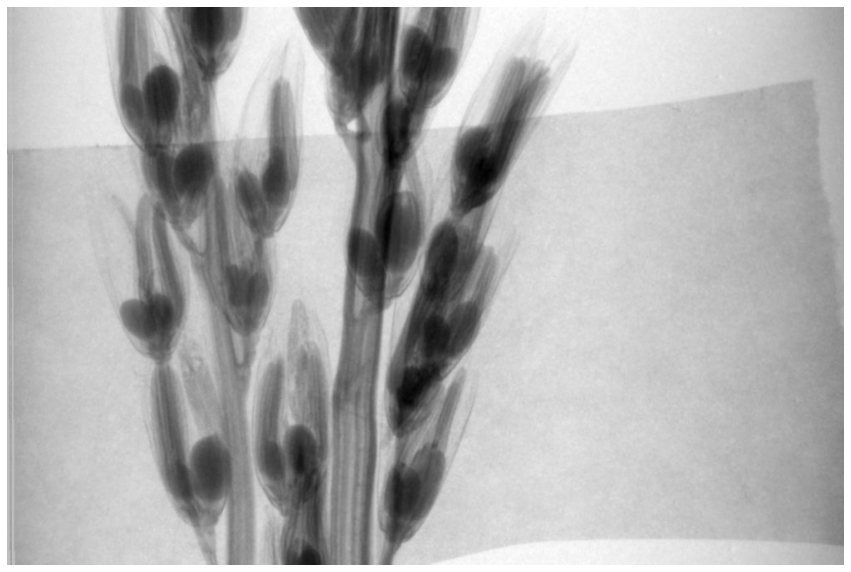

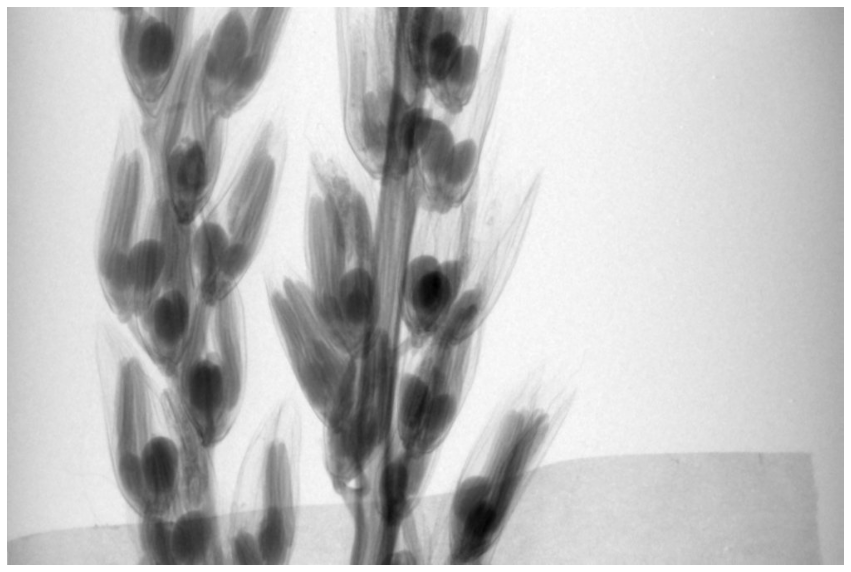

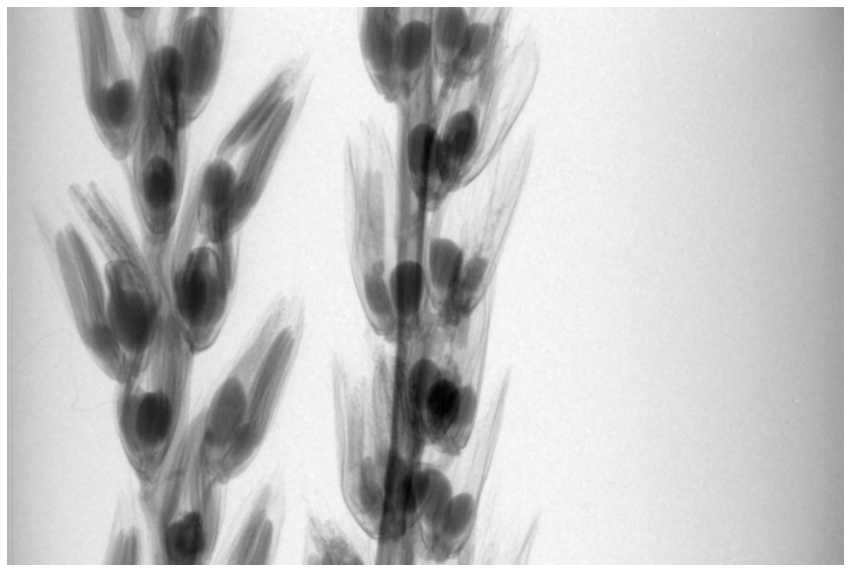

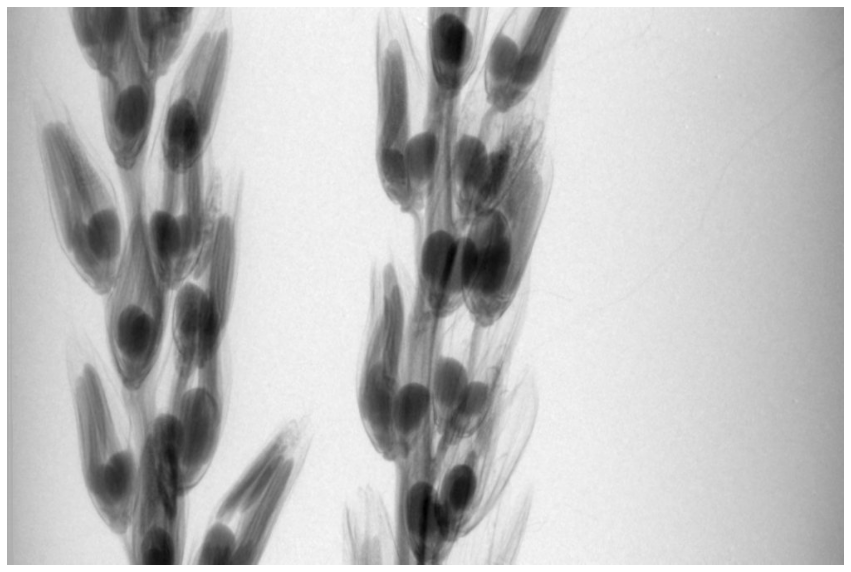

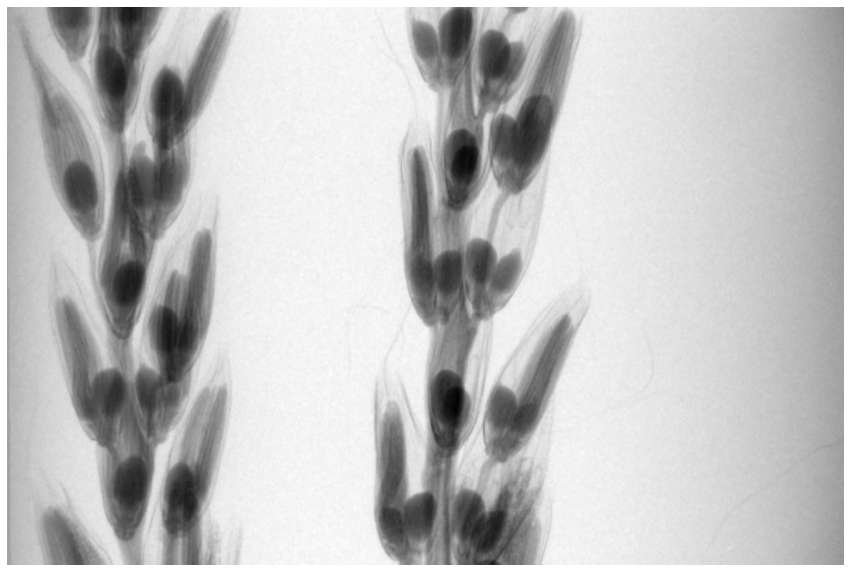

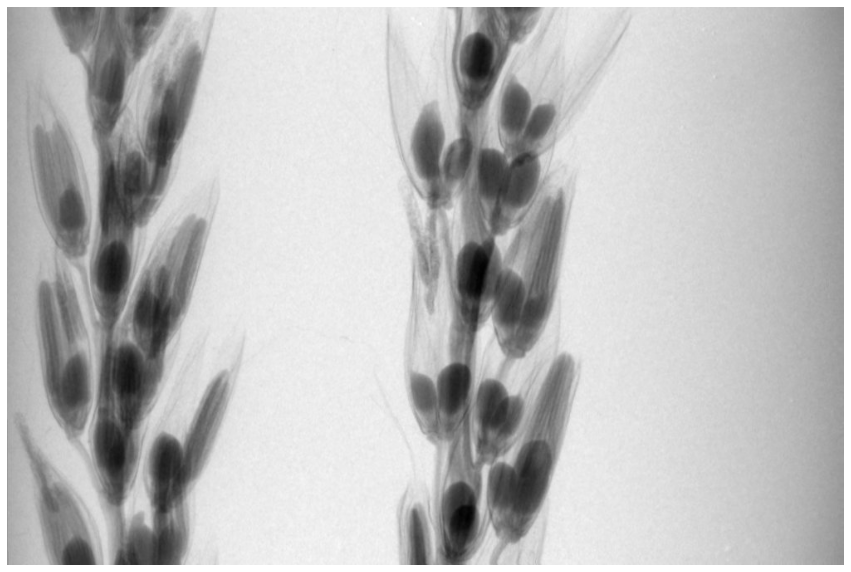

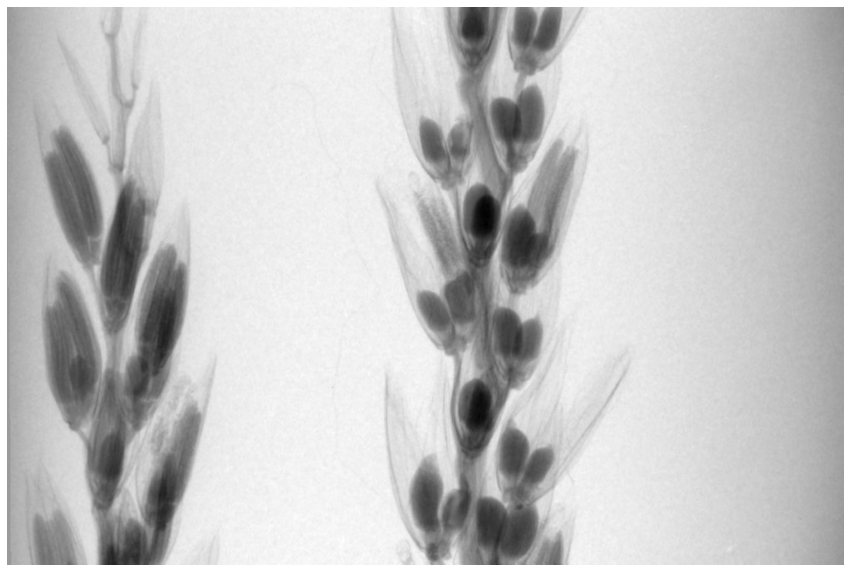

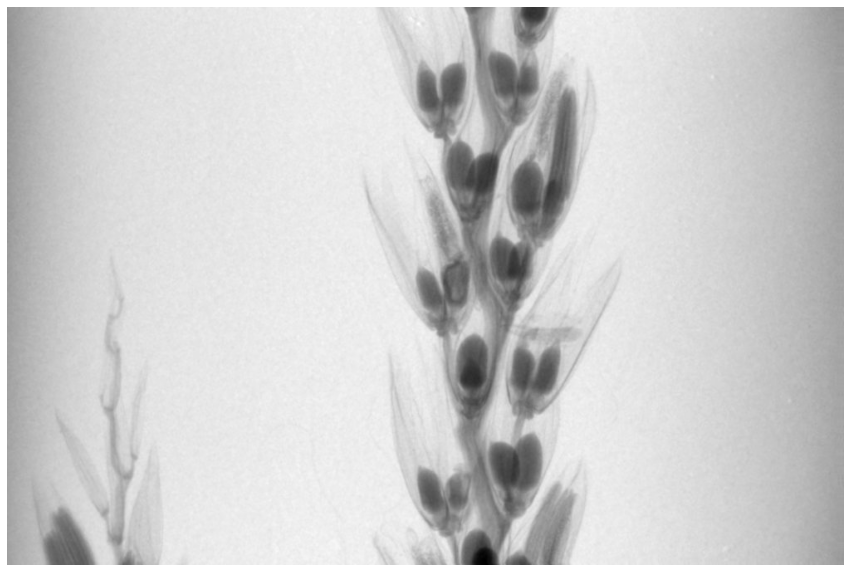

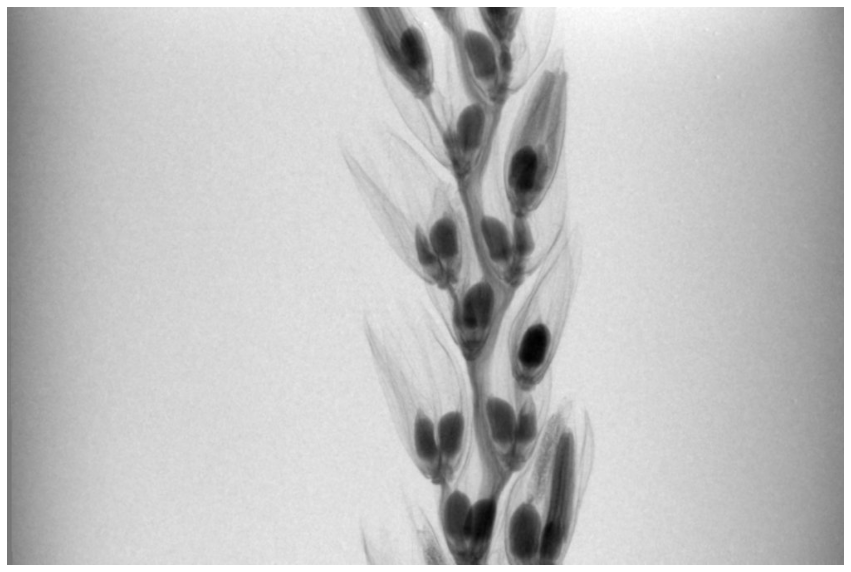

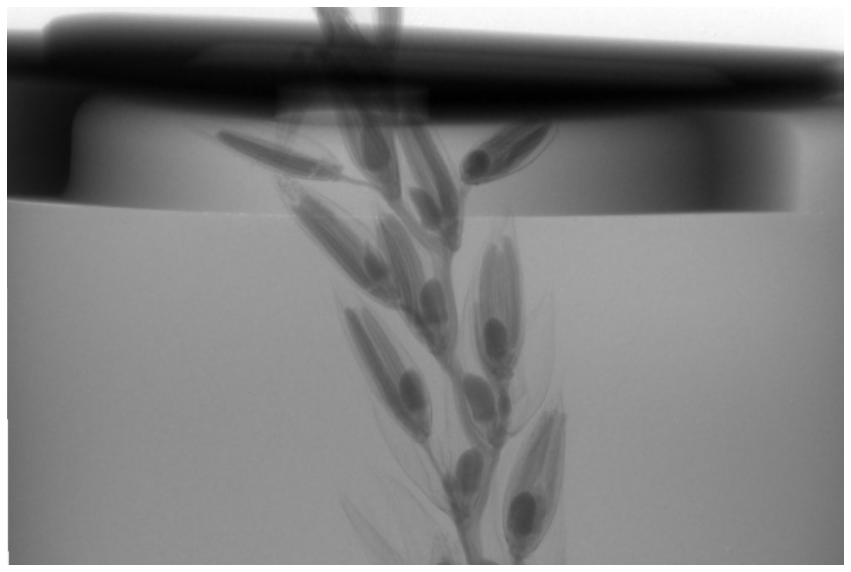

In [119]:
show_images(all_imgs_updated)

In [ ]:
#overlay carpel masks on imgs

In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask
import ast
import matplotlib.patches as patches

def show_image_with_rle_masks(image_id, finalDf, image_path):
    # Filter rows for the given image_id
    image_rows = finalDf[finalDf['image_id'] == image_id]
    if image_rows.empty:
        print(f"No data found for image_id {image_id}")
        return
    
    # Load the image (BGR)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not load image with image_id {image_id}")
        return

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Decode RLE masks
    image_masks = []
    for idx, row in image_rows.iterrows():
        try:
            pmask = mask.decode(ast.literal_eval(row['segm']))
            image_masks.append(pmask)
        except ValueError as e:
            print(f"Skipping malformed segment in row {idx}: {e}")

    # Show image
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_rgb)
    ax.axis('off')

    # Set mask color to yellow
    mask_color = (100, 149, 237) #'cornflowerblue' #(255, 255, 0)  # Yellow in (R,G,B)
    alpha_value = 125           # Transparency for the overlay

    for pmask in image_masks:
        rgba_mask = np.zeros((img_rgb.shape[0], img_rgb.shape[1], 4), dtype=np.uint8)
        rgba_mask[pmask == 1, :3] = mask_color
        rgba_mask[pmask == 1, 3] = alpha_value
        
        # Overlay the mask
        ax.imshow(rgba_mask)

        # Now add a darker outline around the mask
        # Convert pmask to uint8 for findContours
        pmask_uint8 = (pmask * 255).astype(np.uint8)
        
        # Find contours
        contours, _ = cv2.findContours(pmask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw polygon outlines around each contour
        # Choose a darker outline color, e.g. black
        outline_color = 'yellow'

        for cnt in contours:
            # Convert contour to a polygon
            # Contour format: (N, 1, 2) -> get rid of the redundant dimension
            poly_coords = cnt.reshape(-1, 2)
            
            polygon = patches.Polygon(poly_coords, closed=True, 
                                      edgecolor=outline_color, linewidth=1, facecolor='none')
            ax.add_patch(polygon)

    plt.show()


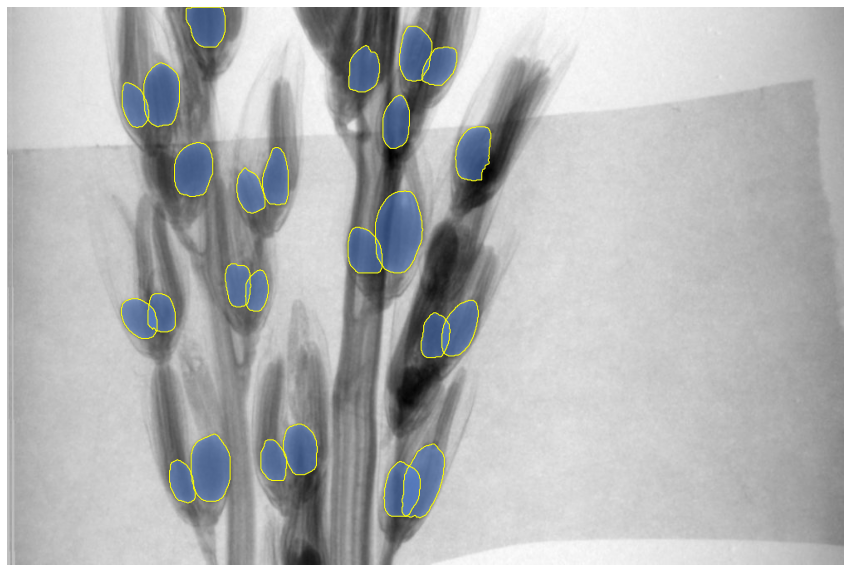

In [164]:
show_image_with_rle_masks(all_imgs[0], df2, all_imgs_updated[0])

In [165]:
len(all_imgs)

10

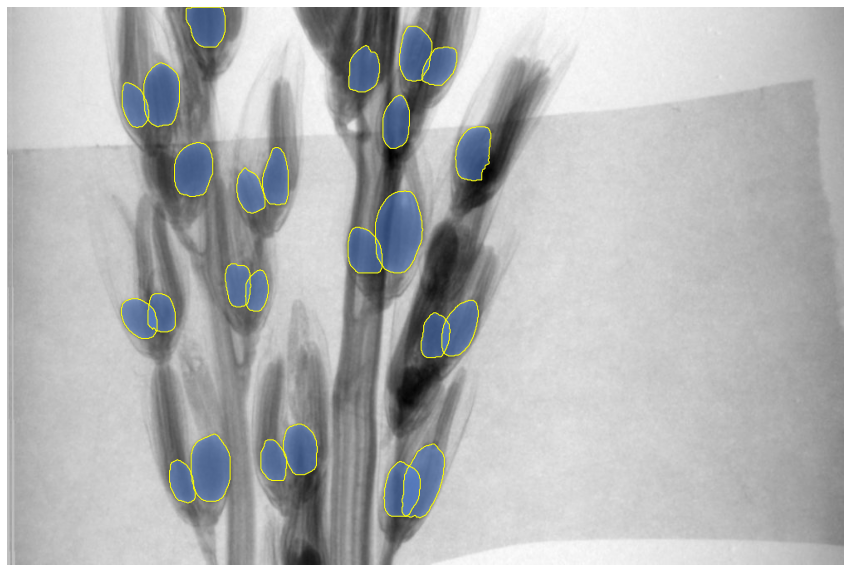

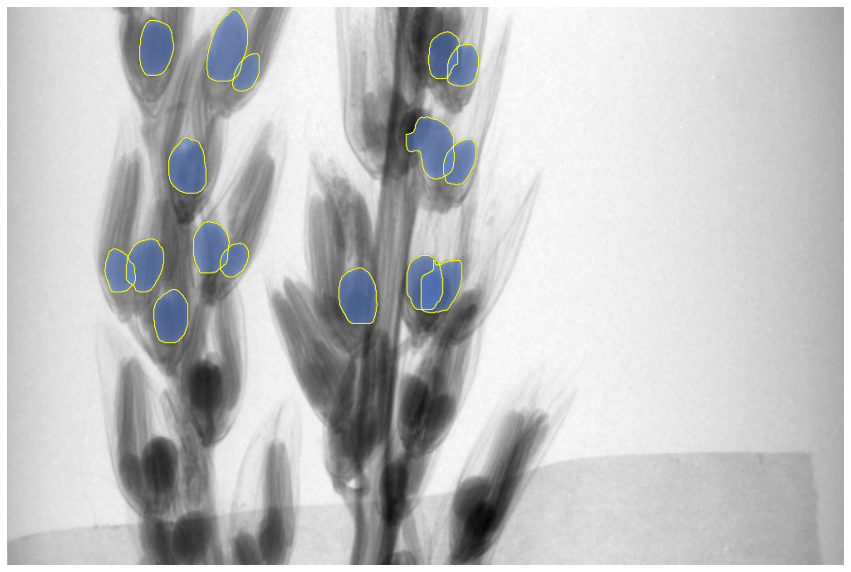

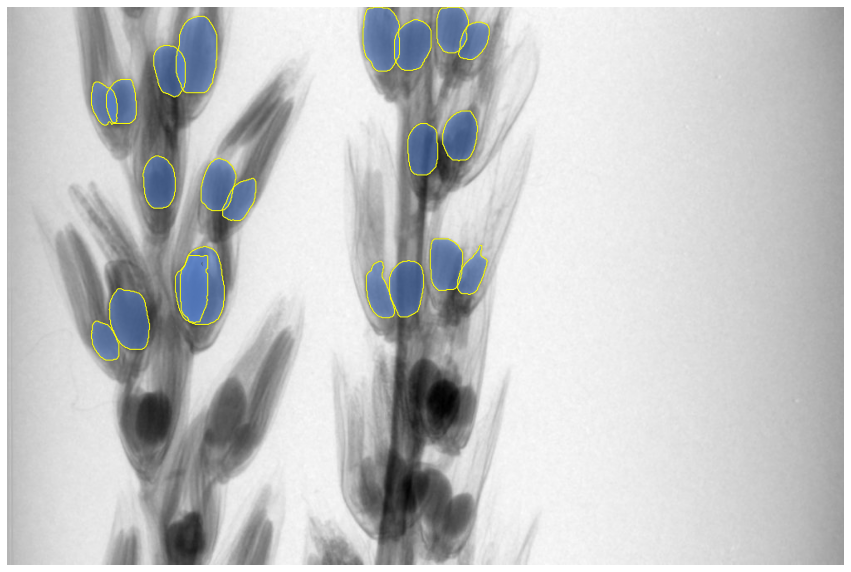

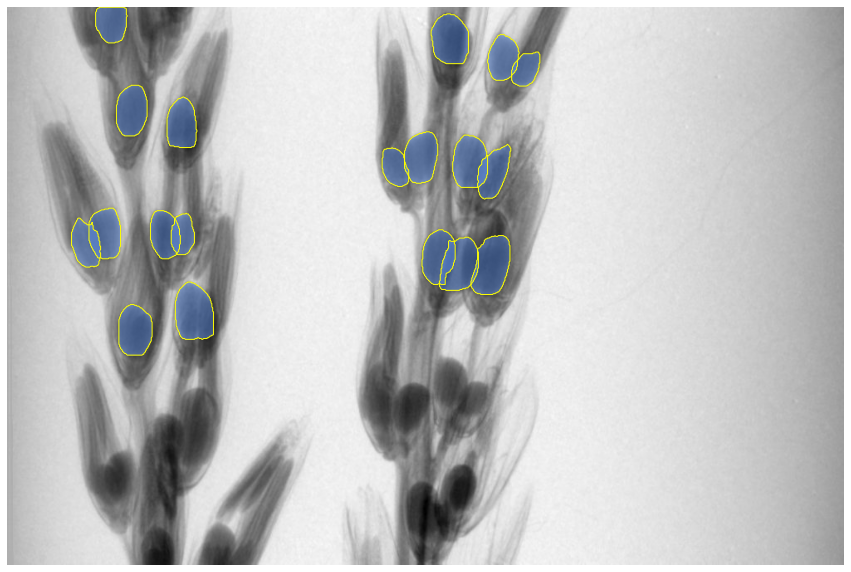

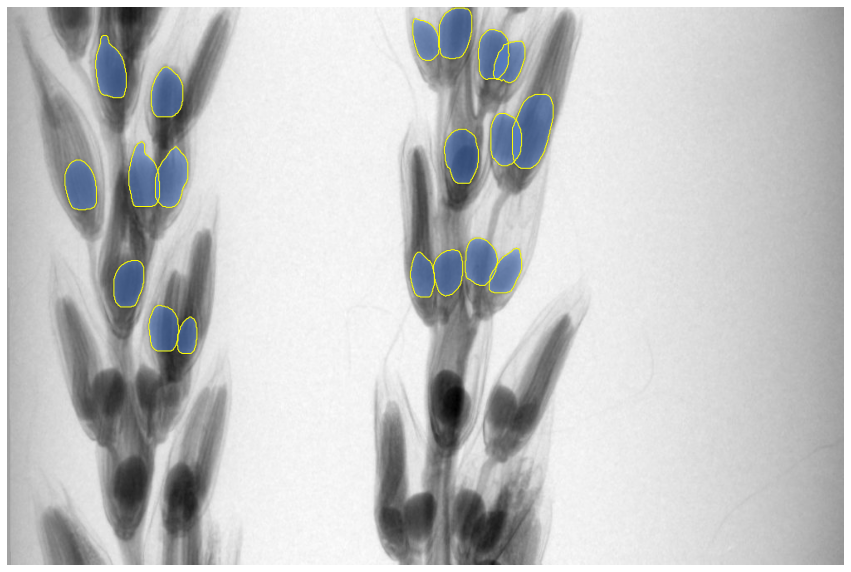

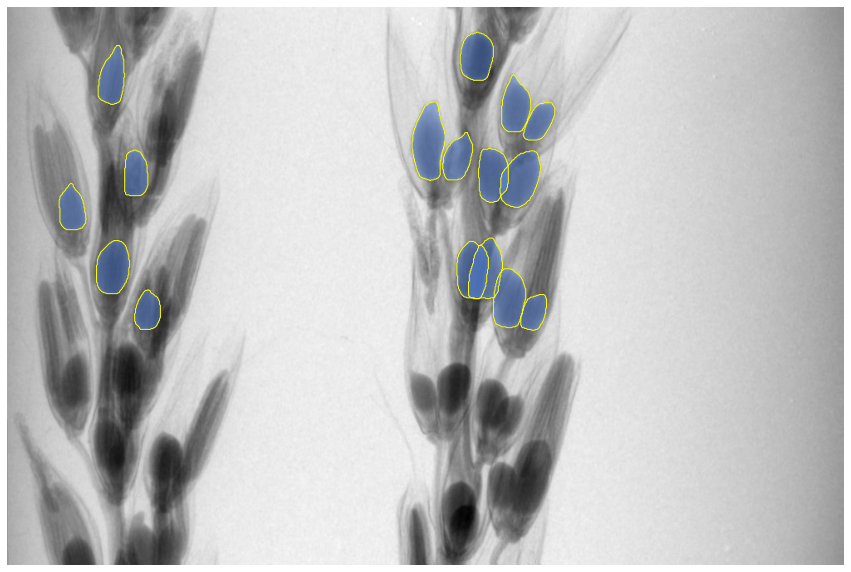

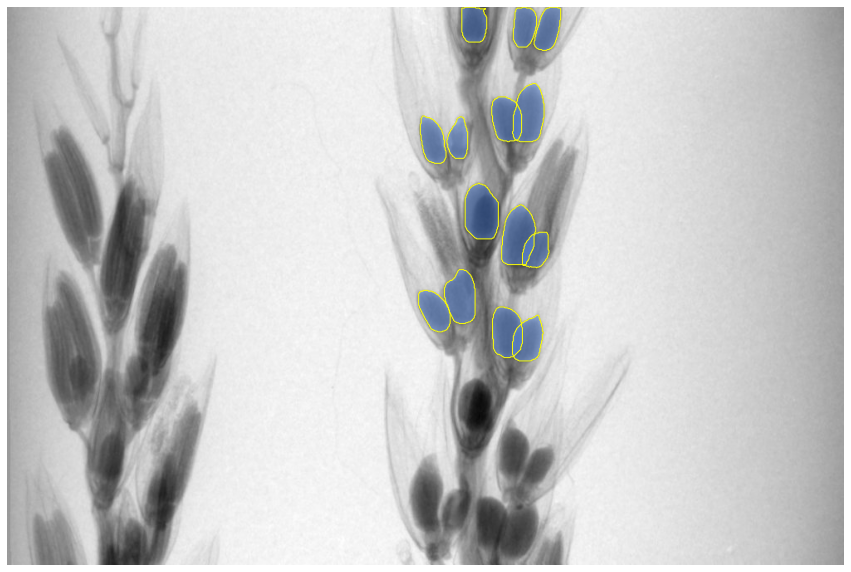

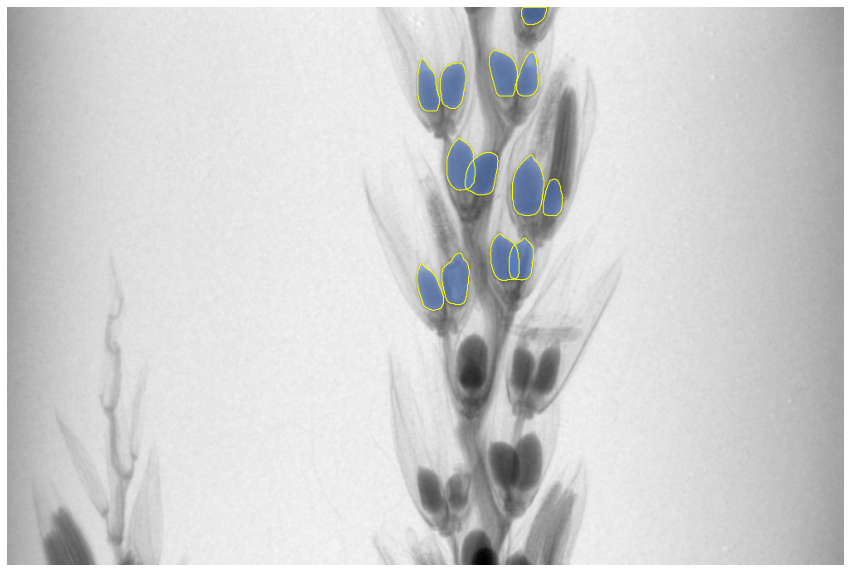

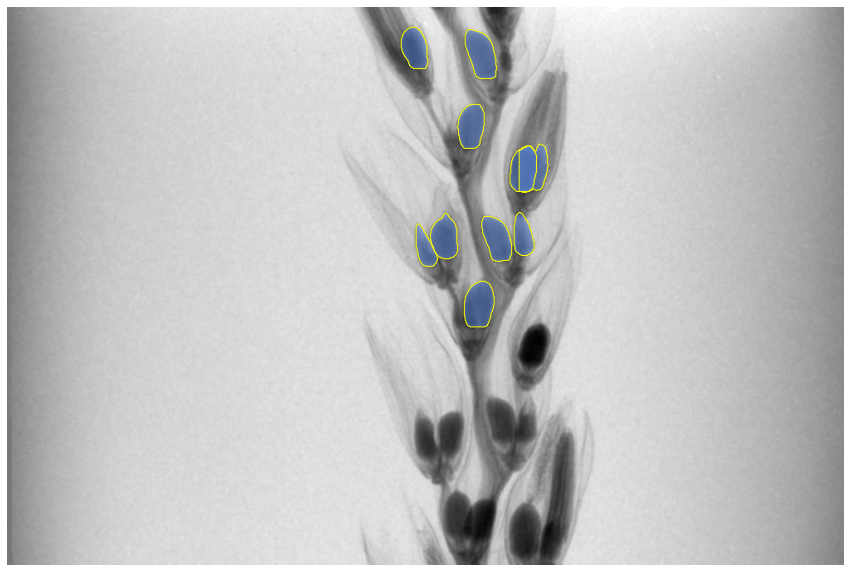

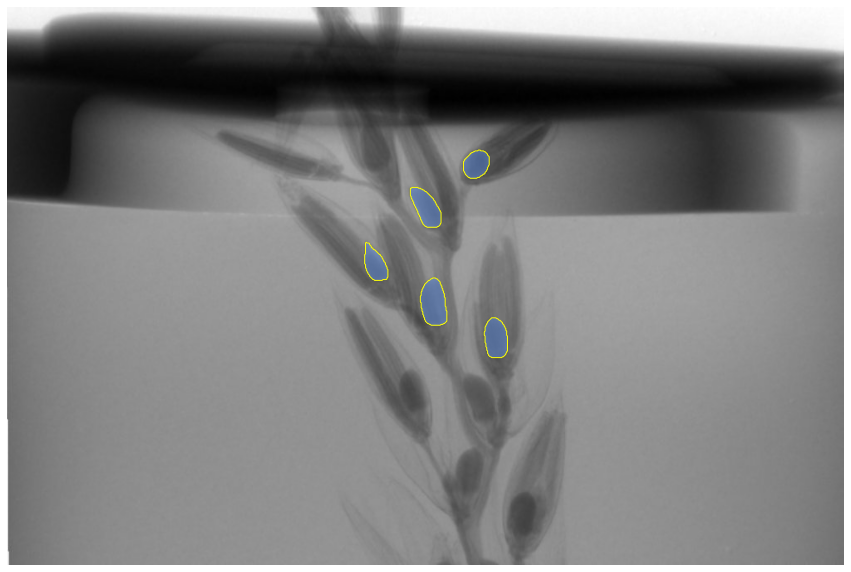

In [167]:
for x in range(0,10):
    show_image_with_rle_masks(all_imgs[x], df2, all_imgs_updated[x])